In [302]:
#Biblioteket
import numpy as np
import matplotlib.pyplot as plt

In [303]:
#Enklar deklaratioer av konstanter
mu = 3        #Friktionskoffecient 2=<mu<=4, vi valde medelvärdet
g = 9.82      #(m/s^2) tyngdfaktor

Cd = 0.3      #luftmotståndskoeffecient ENHETSLÖS!
Af = 1.63     #(m^2) frontarea
p_air = 1.2   #(kg/m^3)   luftdensitet 

C_rr = 0.03   #rullmotståndskoffecient 

In [304]:
#Implementering av ekvationerna som vi har från In 2 del (TEKNISKA KRAV)       
def F_aero(Hast):  #(N) Luftmotstånds-kraft
    F_aero = 0.5 * Cd * Af * p_air * Hast**2
    return F_aero

def F_roll(grad, mass):   #(N) Rullmotståndets kraftkomposant
    return C_rr * mass * g * np.cos(grad)

def F_grad(grad, mass):     #(N) Den vertikala gradientens kraftkomposant 
    F_grad= mass * g * np.sin(grad)
    return F_grad


In [305]:
#Implementering av ekvationerna som vi har från In 2 del (FYSIKALISK MODELL)

#----------------------Enkla Deklarationer--------------------------------------
lamda = 10.03 * 2.325        #(Wb) Flödeskonstant
Ra = 0.039 * 2.325           #(Ohm) Resistans 
r_hjul = 0.46482             #(m) 36.6 (inches) / 2 *0.0254 = 0.46482 (m)
T_f = 15.905 * 2.325         #(Nm) Friktionsförluster i motor
n = 0.982                    #Verkningsgrad ENHETSLÖS!
i = 5                      #Utväxlingen ENHETSLÖS! (Vi valde planet Växel)

#-----------------------Ekvationer----------------------------------------------
def T_e(ia):            #(Nm) Motorvridmoment
    T_e= ia * lamda
    return T_e

def w_r(v_veh):             #(rad/s) varvtal för elmotorn
    w_r= (v_veh/r_hjul)/i     
    return w_r



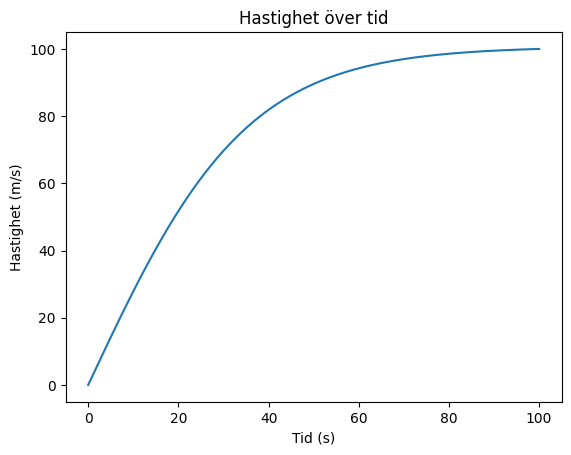

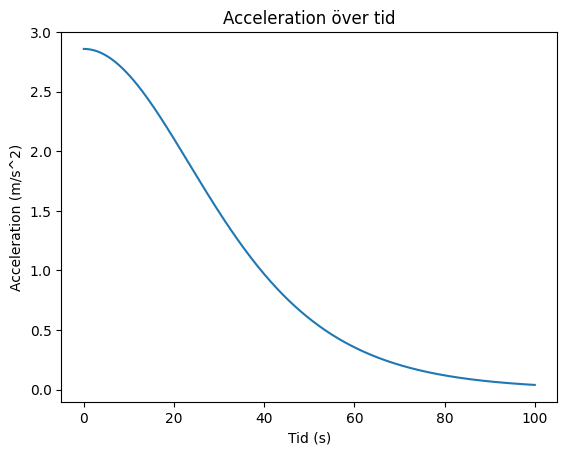

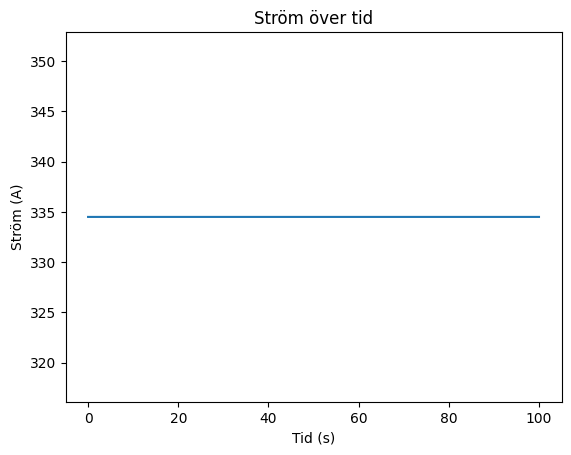

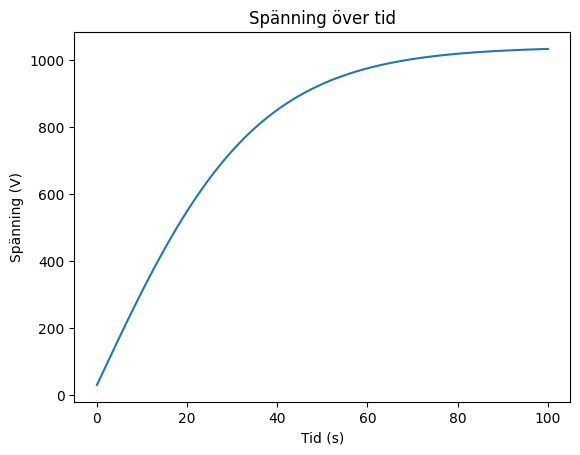

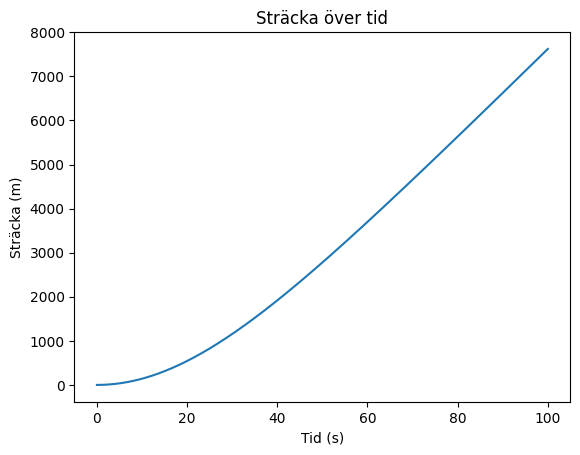

In [ ]:
#=============================================================================
#-----------------------Simulering--------------------------------------------
#=============================================================================
#-----------------Simulering funktion-----------------------------------------
simtyp = 0                          #Variabel för att bestämma spänning- eller ström styrd
m = 1040                        #(kg) massan
alpha = 0                       #(grader) lutningen i radianer (grader * pi/180)
U = 2679                        #(v) 
I = 669/2                         #(A)
noise = 0.5                    #Standardavvikelse för brus i sensorn
mf = mf = np.random.uniform(-0.02, 0.02)                    #Fel i mätning

def sim(m,alpha, U, I):         #simulerig med insignalerna m, alpha, U, I 
    N = 100000                   #Antal iterrationer 
    dt = 0.001                 #(s) Tidsteg (start fråm 1ms)
#------------------Skapar vektorer för att lagra in resultat---------------------
    t_vec = np.zeros(N)         #tid            ex.[0,0,....,0]
    v_vec = np.zeros(N)         #hastighet      ex.[0,0,....,0]
    a_vec = np.zeros(N)         #acceleration   ex.[0,0,....,0]
    ia_vec = np.zeros(N)        #ankarstörm     ex.[0,0,....,0]
    U_vec = np.zeros(N)         #spänning       ex.[0,0,....,0]
    s_vec = np.zeros(N)         #sträcka        ex.[0,0,....,0]
    Sensor = np.zeros(N)         #Sensor mättvärden        ex.[0,0,....,0]

    for k in range(0,N):        #Från 0 till 999 (1000 iter.)

        t_vec[k]= k * dt                                #Sparar tiden för tillstånd k 

        #Mekaniska krafter från omvärden som verkar på fordonet
        F_aero_1 = F_aero(v_vec[k])                     #Räknar luftmotsåndet i tillstånd k för hastigheten i det tillståndet
        F_roll_1 = F_roll(alpha, m)                     #Räknar friktion i tillstånd k för hastigheten i det tillståndet
        F_grad_1 = F_grad(alpha, m)                     #Räknar lutning i tillstånd k för hastigheten i det tillståndet
        F_motstånd = F_aero_1 + F_roll_1 + F_grad_1     #Totala motståndet som verkar på fordonet
        #Mekaniska kraften vi får från motorn

        if simtyp==1:                                       #Fallet spänningstyrd

            ia_vec[k] = (U - lamda * w_r(v_vec[k]))/Ra
            if ia_vec[k] > I:                                    #Begränsar strömmen till max ström
                ia_vec[k] = I
            U_vec[k] =  U

        else:                                               #Strömstyrd
            U_vec[k] = I * Ra + lamda * w_r(v_vec[k])       #Sparar värden för späningen för varje tillstånd
            if U_vec[k] > U:                                #Begränsar spänningen till max spänning
                U_vec[k] = U
            ia_vec[k] = I                                   #Sparar värden för strömmen för varje tillstånd
        
        T_hjul = n*(T_e(ia_vec[k])-T_f)/i                  #(Nm) Räknar hjulensvridmoment beroende av strömmen

        F_trac = T_hjul/r_hjul                              #(N) Dragkraften vid hjulen

        F_net = F_trac - F_motstånd                         #(N) Nettokraften som får fordonet att röra sig

        a = F_net/m                                         #(m/s^2) Accelerationen

        if a > (mu * g * np.cos(alpha)):                               #Kollar om accelerationen är större än max acceleration
            a = mu * g * np.cos(alpha)                                 #Sätter accelerationen till max acceleration
        a_vec[k] = a                                        #Sparar accelerationen i vektorn

        # Sensor[k] = v_vec[k] - ((1 + mf) * v_vec[k] + np.random.normal(0, noise))
        # Sensor[k] = v_vec[k] (1 + mf) * v_vec[k] + np.random.normal(0, noise)

        if k < (N - 1):
            v_vec[k+1] = v_vec[k] + (a * dt)            #(Eulers-metod) Sparar hastigheten i nästa tillstånd
            #S = v * t + (a*t^2)/2
            s_vec[k+1] = s_vec[k] + (v_vec[k] * dt) + (a * (dt**2)) / 2 #Sparar sträckan i nästa tillstånd
    
#------------------------------------Plotar vektorerna -------------------------------
    #0 = ingen graf, 1 = fem separata, 2 = en sammanställd
    toggle = 1   #Ändra denna om du vill byta graf
    if toggle == 1:
        plt.plot(t_vec,v_vec)
        plt.title("Hastighet över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.show()

        plt.plot(t_vec,a_vec)
        plt.title("Acceleration över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Acceleration (m/s^2)")
        plt.show()

        plt.plot(t_vec,ia_vec)
        plt.title("Ström över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Ström (A)")
        plt.show()
        
        plt.plot(t_vec,U_vec)
        plt.title("Spänning över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Spänning (V)")
        plt.show()

        plt.plot(t_vec,s_vec)
        plt.title("Sträcka över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Sträcka (m)")
        plt.show()

        plt.plot(t_vec,Sensor)
        plt.title("???")
        plt.xlabel("???")
        plt.ylabel("???")
        plt.show()
    #Om man vill ha allt i en graf:
    if toggle == 2:
        plt.plot(t_vec, v_vec, label="Hastighet")
        plt.plot(t_vec, a_vec, label="Acceleration")
        plt.plot(t_vec, ia_vec, label="Ström")
        plt.plot(t_vec, U_vec, label="Spänning")
        plt.plot(t_vec, s_vec, label="Sträcka")
        plt.title("Sammanställd graf")
        plt.xlabel("Tid (s)")
        plt.ylabel("Mätdata")
        plt.legend()
        plt.grid(True)
        plt.show()
sim(m, alpha, U, I)